In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hyperopt import tpe, fmin, hp
from hyperopt.pyll.base import scope
from sklearn.decomposition import PCA
import shap
import torch
from torch import nn 
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [2]:
data=pd.read_csv('C:/Users/71908/Desktop/Predictors for extubation/data/data-final.csv')

In [3]:
data

,group_7d,group_48h,age,bmi,surgery_type,hb_mean,platelet_mean,wbc_mean,po2_mean,pco2_mean,...,fio2_mean,hr_mean,mbp_mean,spo2_mean,congestive_heart_failure,cerebrovascular_disease,chronic_pulmonary_disease,renal_disease,liver_disease,diabetes
0,0,0,71.489037,31.799974,2,9.275,166.250000,15.000000,146.77777,50.555557,...,47.500000,76.393936,67.891891,97.038460,1,0,1,0,0,1
1,0,0,56.219223,32.744930,1,9.050,92.000000,18.049999,147.20000,37.400002,...,40.000000,86.080002,92.599998,97.839996,1,0,0,1,0,0
2,1,1,86.771370,27.262625,1,9.800,67.666664,12.750000,76.00000,37.285713,...,70.833336,90.595238,64.511627,93.761902,1,0,1,1,1,1
3,1,0,85.973587,23.985310,3,10.200,186.000000,21.600000,118.60000,33.200001,...,40.909092,78.500000,73.941177,98.606064,1,0,0,1,0,0
4,0,0,76.054535,28.405506,1,10.700,187.000000,13.100000,117.00000,39.599998,...,42.857143,70.919998,75.599998,96.480003,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,0,0,78.832451,29.414825,1,9.250,164.000000,9.750000,114.60000,33.599998,...,43.750000,80.807693,77.057693,99.230766,0,0,0,1,0,0
772,0,0,66.436714,22.733261,1,9.025,167.666670,9.633333,225.75000,38.000000,...,50.000000,69.218750,62.806450,97.645164,1,1,1,0,0,0
773,0,0,69.815598,33.587898,2,9.600,162.000000,24.799999,94.50000,39.500000,...,63.000000,97.599998,70.440002,93.961540,1,1,0,0,0,1
774,0,0,55.665543,31.208057,2,9.875,89.750000,18.875000,91.50000,38.750000,...,38.333332,80.519997,73.048782,96.879997,1,0,1,0,0,0


In [4]:
np.sum(data["group_7d"] == 0)

571

In [5]:
np.sum(data["group_7d"] == 1)

205

In [6]:
np.sum(data["group_48h"] == 0)

646

In [7]:
np.sum(data["group_48h"] == 1)

130

In [8]:
from sklearn import preprocessing

# Extract Labels Before Standardization
labels = data['group_7d']
data.drop(['group_7d'], axis=1, inplace=True)


In [9]:
data

,group_48h,age,bmi,surgery_type,hb_mean,platelet_mean,wbc_mean,po2_mean,pco2_mean,pao2fio2ratio_mean,...,fio2_mean,hr_mean,mbp_mean,spo2_mean,congestive_heart_failure,cerebrovascular_disease,chronic_pulmonary_disease,renal_disease,liver_disease,diabetes
0,0,71.489037,31.799974,2,9.275,166.250000,15.000000,146.77777,50.555557,250.73334,...,47.500000,76.393936,67.891891,97.038460,1,0,1,0,0,1
1,0,56.219223,32.744930,1,9.050,92.000000,18.049999,147.20000,37.400002,386.66666,...,40.000000,86.080002,92.599998,97.839996,1,0,0,1,0,0
2,1,86.771370,27.262625,1,9.800,67.666664,12.750000,76.00000,37.285713,106.15646,...,70.833336,90.595238,64.511627,93.761902,1,0,1,1,1,1
3,0,85.973587,23.985310,3,10.200,186.000000,21.600000,118.60000,33.200001,296.50000,...,40.909092,78.500000,73.941177,98.606064,1,0,0,1,0,0
4,0,76.054535,28.405506,1,10.700,187.000000,13.100000,117.00000,39.599998,260.00000,...,42.857143,70.919998,75.599998,96.480003,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,0,78.832451,29.414825,1,9.250,164.000000,9.750000,114.60000,33.599998,269.39999,...,43.750000,80.807693,77.057693,99.230766,0,0,0,1,0,0
772,0,66.436714,22.733261,1,9.025,167.666670,9.633333,225.75000,38.000000,494.12500,...,50.000000,69.218750,62.806450,97.645164,1,1,1,0,0,0
773,0,69.815598,33.587898,2,9.600,162.000000,24.799999,94.50000,39.500000,200.53572,...,63.000000,97.599998,70.440002,93.961540,1,1,0,0,0,1
774,0,55.665543,31.208057,2,9.875,89.750000,18.875000,91.50000,38.750000,233.33333,...,38.333332,80.519997,73.048782,96.879997,1,0,1,0,0,0


In [10]:

data.drop(['group_48h'], axis=1, inplace=True)

In [11]:
data


,age,bmi,surgery_type,hb_mean,platelet_mean,wbc_mean,po2_mean,pco2_mean,pao2fio2ratio_mean,ph_mean,...,fio2_mean,hr_mean,mbp_mean,spo2_mean,congestive_heart_failure,cerebrovascular_disease,chronic_pulmonary_disease,renal_disease,liver_disease,diabetes
0,71.489037,31.799974,2,9.275,166.250000,15.000000,146.77777,50.555557,250.73334,7.256667,...,47.500000,76.393936,67.891891,97.038460,1,0,1,0,0,1
1,56.219223,32.744930,1,9.050,92.000000,18.049999,147.20000,37.400002,386.66666,7.496000,...,40.000000,86.080002,92.599998,97.839996,1,0,0,1,0,0
2,86.771370,27.262625,1,9.800,67.666664,12.750000,76.00000,37.285713,106.15646,7.317143,...,70.833336,90.595238,64.511627,93.761902,1,0,1,1,1,1
3,85.973587,23.985310,3,10.200,186.000000,21.600000,118.60000,33.200001,296.50000,7.424000,...,40.909092,78.500000,73.941177,98.606064,1,0,0,1,0,0
4,76.054535,28.405506,1,10.700,187.000000,13.100000,117.00000,39.599998,260.00000,7.416000,...,42.857143,70.919998,75.599998,96.480003,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,78.832451,29.414825,1,9.250,164.000000,9.750000,114.60000,33.599998,269.39999,7.402000,...,43.750000,80.807693,77.057693,99.230766,0,0,0,1,0,0
772,66.436714,22.733261,1,9.025,167.666670,9.633333,225.75000,38.000000,494.12500,7.382500,...,50.000000,69.218750,62.806450,97.645164,1,1,1,0,0,0
773,69.815598,33.587898,2,9.600,162.000000,24.799999,94.50000,39.500000,200.53572,7.237500,...,63.000000,97.599998,70.440002,93.961540,1,1,0,0,0,1
774,55.665543,31.208057,2,9.875,89.750000,18.875000,91.50000,38.750000,233.33333,7.505000,...,38.333332,80.519997,73.048782,96.879997,1,0,1,0,0,0


In [12]:
# Standardize Data
standard_data = data.copy()
scaler = preprocessing.StandardScaler()
standard_data.iloc[:,:] = scaler.fit_transform(data.iloc[:,:])
standard_data

,age,bmi,surgery_type,hb_mean,platelet_mean,wbc_mean,po2_mean,pco2_mean,pao2fio2ratio_mean,ph_mean,...,fio2_mean,hr_mean,mbp_mean,spo2_mean,congestive_heart_failure,cerebrovascular_disease,chronic_pulmonary_disease,renal_disease,liver_disease,diabetes
0,0.141771,0.420092,0.236623,-0.406172,0.388877,0.207961,0.775789,2.452327,-0.067217,-2.478422,...,-0.141853,-0.680949,-0.632913,-0.297334,0.855653,-0.483430,1.526588,-0.701646,-0.327093,1.263059
1,-1.041653,0.577192,-1.047429,-0.592400,-0.606572,0.705990,0.788469,-0.152296,1.568249,1.486861,...,-0.898619,0.090993,3.079537,0.164730,0.855653,-0.483430,-0.655055,1.425219,-0.327093,-0.791729
2,1.326165,-0.334248,-1.047429,0.028363,-0.932803,-0.159437,-1.349745,-0.174924,-1.806676,-1.476447,...,2.212530,0.450840,-1.140805,-2.186182,0.855653,-0.483430,1.526588,1.425219,3.057232,1.263059
3,1.264336,-0.879105,1.520675,0.359437,0.653660,1.285663,-0.070420,-0.983840,0.483419,0.293961,...,-0.806890,-0.513104,0.276006,0.606348,0.855653,-0.483430,-0.655055,1.425219,-0.327093,-0.791729
4,0.495601,-0.144243,-1.047429,0.773280,0.667067,-0.102286,-0.118470,0.283273,0.044274,0.161418,...,-0.610327,-1.117201,0.525248,-0.619269,0.855653,-0.483430,-0.655055,1.425219,-0.327093,-0.791729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,0.710892,0.023558,-1.047429,-0.426864,0.358712,-0.649301,-0.190545,-0.904646,0.157369,-0.070533,...,-0.520236,-0.329190,0.744270,0.966472,-1.168697,-0.483430,-0.655055,1.425219,-0.327093,-0.791729
772,-0.249788,-1.087260,-1.047429,-0.613093,0.407870,-0.668352,3.147412,-0.033505,2.861121,-0.393606,...,0.110402,-1.252784,-1.397012,0.052415,0.855653,2.068553,1.526588,-0.701646,-0.327093,-0.791729
773,0.012078,0.717336,0.236623,-0.137173,0.331899,1.808185,-0.794170,0.263475,-0.671163,-2.795973,...,1.422130,1.009093,-0.250053,-2.071096,0.855653,2.068553,-0.655055,-0.701646,-0.327093,1.263059
774,-1.084563,0.321685,0.236623,0.090440,-0.636737,0.840703,-0.884263,0.114985,-0.276563,1.635978,...,-1.066789,-0.352118,0.141922,-0.388683,0.855653,-0.483430,1.526588,-0.701646,-0.327093,-0.791729


In [13]:
for col in data.columns:
    print(col)

age
bmi
surgery_type
hb_mean
platelet_mean
wbc_mean
po2_mean
pco2_mean
pao2fio2ratio_mean
ph_mean
lactate_mean
aniongap_mean
bicarbonate_mean
bun_mean
calcium_mean
chloride_mean
creatinine_mean
glucose_mean
sodium_mean
potassium_mean
rr_mean
mv_mean
vt_mean
pplat_mean
peep_mean
fio2_mean
hr_mean
mbp_mean
spo2_mean
congestive_heart_failure
cerebrovascular_disease
chronic_pulmonary_disease
renal_disease
liver_disease
diabetes


In [14]:
##可视化


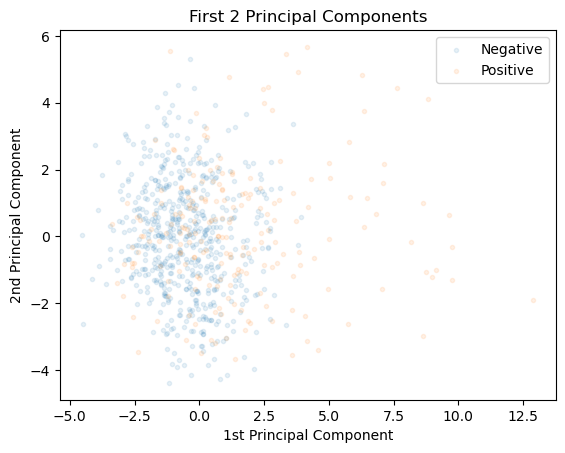

In [15]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(standard_data.iloc[:,:])
plt.figure()
plt.scatter(pca_data[labels==0][:, 0], pca_data[labels==0][:, 1], alpha = 0.1, marker='.')
plt.scatter(pca_data[labels==1][:, 0], pca_data[labels==1][:, 1], alpha=0.1, marker='.')
plt.legend(["Negative", "Positive"])
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.title("First 2 Principal Components")
plt.show()